## Imports y dependencias

In [ ]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import optuna

import time
from datetime import timedelta
from tqdm.notebook import tqdm

from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

### Funciones desarrolladas

In [ ]:
# función para imprimir las métricas ROC AUC y LIFT
def evaluar_modelo(y_true, y_pred_proba, top_percentiles=[1, 5, 10]):
    """
    Calcula ROC AUC y LIFT en los percentiles indicados (por defecto 1%, 5%, 10%).
    
    Args:
        y_true: array-like, etiquetas reales (0 o 1) -el target-
        y_pred_proba: array-like, probabilidades predichas para la clase positiva
        top_percentiles: lista de percentiles a evaluar para el Lift

    Returns:
        None (imprime las métricas)
    """
    # Crear DataFrame ordenado por score
    df = pd.DataFrame({
        "y_true": y_true,
        "y_score": y_pred_proba
    }).sort_values(by="y_score", ascending=False).reset_index(drop=True)

    # ROC AUC
    auc = roc_auc_score(df["y_true"], df["y_score"])
    print(f"\tROC AUC: {auc:.4f}")

    # Tasa base (porcentaje de positivos en todo el dataset)
    tasa_base = df["y_true"].mean()
    
    lifts = {}
    # Calcular Lift en cada top X%
    for p in top_percentiles: #top_percentiles=[1, 5, 10]
        corte = int(len(df) * p / 100)
        top_df = df.iloc[:corte]
        tasa_top = top_df["y_true"].mean()
        lift = tasa_top / tasa_base if tasa_base > 0 else 0
        lifts[p]=lift
        print(f"\tLift @ top {p}%: {lift:.2f}x")
    return auc, lifts


def predict_en_batches(modelo, X, batch_size=512):
    probas = []
    n = len(X)

    for i in tqdm(range(0, n, batch_size), desc="Procesando batches de entrenamiento para TabPFN"):
        batch = X.iloc[i:i+batch_size]
        probas_batch = modelo.predict_proba(batch)[:, 1]
        probas.extend(probas_batch)

    return np.array(probas)

#Funciones de PLOTS
def graficar_metricas_comparadas(df_metrics_1, df_metrics_2,
                                 nombre_modelo_1="Modelo 1", nombre_modelo_2="Modelo 2",
                                 lift_percentiles=[1, 5, 10]):
    """
    Genera gráficos comparando la evolución de ROC AUC y Lifts de dos modelos.

    Parámetros:
        df_metrics_1 (pl.DataFrame): Métricas del modelo 1
        df_metrics_2 (pl.DataFrame): Métricas del modelo 2
        nombre_modelo_1 (str): Nombre del modelo 1 (para la leyenda)
        nombre_modelo_2 (str): Nombre del modelo 2 (para la leyenda)
        lift_percentiles (list): Lista de percentiles usados para calcular lift
        zoom (bool): Si True, muestra gráficos adicionales con zoom en X
    """

    def plot_conjunto(axs, datos1, datos2, titulo=None):
        # Gráfico 1: ROC AUC
        axs[0].plot(datos1["n_features"].to_list(), datos1["roc_auc"].to_list(),
                    marker='o', label=f"ROC AUC ({nombre_modelo_1})")
        axs[0].plot(datos2["n_features"].to_list(), datos2["roc_auc"].to_list(),
                    marker='o', label=f"ROC AUC ({nombre_modelo_2})")
        axs[0].set_title("Evolución del ROC AUC")
        axs[0].set_xlabel("Número de muestras")
        axs[0].set_ylabel("ROC AUC")
        axs[0].invert_xaxis()
        axs[0].grid(True)
        axs[0].legend()

        # Gráficos de LIFT
        for i, p in enumerate(lift_percentiles):
            lift_col = f"lift@{p}%"
            if lift_col in datos1.columns and lift_col in datos2.columns:
                axs[i + 1].plot(datos1["n_features"].to_list(), datos1[lift_col].to_list(),
                                marker='o', label=f"{lift_col} ({nombre_modelo_1})")
                axs[i + 1].plot(datos2["n_features"].to_list(), datos2[lift_col].to_list(),
                                marker='o', label=f"{lift_col} ({nombre_modelo_2})")
                axs[i + 1].set_title(f"Lift en top {p}%")
                axs[i + 1].set_xlabel("Número de muestras")
                axs[i + 1].set_ylabel("Lift")
                axs[i + 1].invert_xaxis()
                axs[i + 1].grid(True)
                axs[i + 1].legend()

    # Gráfico completo
    fig, axes = plt.subplots(1, len(lift_percentiles) + 1, figsize=(5 * (len(lift_percentiles) + 1), 5), sharex=True)
    plot_conjunto(axes, df_metrics_1, df_metrics_2)
    plt.tight_layout()
    plt.show()


#Funciones para búsqueda de hiperparámetros

def optimizar_xgboost_bayesiana(X_train, y_train,scale_pos_weight=1, n_iter=50, cv=3, scoring='roc_auc', random_state=42):
    """
    Optimiza hiperparámetros de XGBoost usando Optuna (optimización bayesiana) con validación cruzada.

    Devuelve:
        study: Objeto de estudio de Optuna con los resultados.
        best_model: Modelo XGBoost con los mejores hiperparámetros encontrados.
    """

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
            "random_state": random_state,
            "eval_metric": "auc"
        }

        model = XGBClassifier(scale_pos_weight=scale_pos_weight,**params)

        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        return np.mean(scores)
    optuna.logging.set_verbosity(optuna.logging.WARNING) #para que no saque prompts
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_iter)

    best_params = study.best_params
    best_params["random_state"] = random_state
    # best_params["use_label_encoder"] = False
    best_params["eval_metric"] = "auc"

    best_model = XGBClassifier(scale_pos_weight=scale_pos_weight,**best_params)
    best_model.fit(X_train, y_train)

    return study, best_model


## Carga de conjuntos ```train``` y ```test```

Carga de columnas seleccionadas

In [3]:
cs = pd.read_csv("xgb_variables30_exploracion.csv")["variable"].to_list()

In [ ]:
# carga de TRAIN (la separación X e y se hace en la propia función del entrenamiento)
df_train = pl.read_csv("df_train.csv")

In [ ]:
# carga de TEST
df_test = pl.read_csv("df_test.csv")

df_positivos = df_test.filter(pl.col("target") == 1)
df_negativos = df_test.filter(pl.col("target") == 0).sample(n=20_000, seed=42) 

# Combinar ambos conjuntos
df_sec = pl.concat([df_positivos, df_negativos]).to_pandas()
X_test = df_sec.drop(columns="target")
X_test = df_sec.apply(pd.to_numeric, errors='coerce')
X_test = pl.from_pandas(X_test)
X_test = X_test.select(cs)

y_test = df_sec["target"]
print("Shape X_test:",X_test.shape)
print("Shape y_test:",y_test.shape)

Shape X_test: (20247, 30)
Shape y_test: (20247,)


## Comparación de modelos

1
Shape X_train: (200, 30)
Shape y_train: (200,)
Error displaying widget: model not found
Tiempo de inferencia TabPFN: 0:03:56.628439
-Métricas XGBoost-
	ROC AUC: 0.6169
	Lift @ top 1%: 2.84x
	Lift @ top 5%: 1.94x
	Lift @ top 10%: 1.78x

-Métricas TabPFN-
	ROC AUC: 0.6064
	Lift @ top 1%: 3.25x
	Lift @ top 5%: 2.02x
	Lift @ top 10%: 1.82x
2
Shape X_train: (400, 30)
Shape y_train: (400,)
Error displaying widget: model not found
Tiempo de inferencia TabPFN: 0:05:42.495244
-Métricas XGBoost-
	ROC AUC: 0.6744
	Lift @ top 1%: 2.43x
	Lift @ top 5%: 2.83x
	Lift @ top 10%: 2.43x

-Métricas TabPFN-
	ROC AUC: 0.6610
	Lift @ top 1%: 1.62x
	Lift @ top 5%: 2.27x
	Lift @ top 10%: 2.31x
3
Shape X_train: (600, 30)
Shape y_train: (600,)
Error displaying widget: model not found
Tiempo de inferencia TabPFN: 0:08:49.476377
-Métricas XGBoost-
	ROC AUC: 0.6627
	Lift @ top 1%: 4.06x
	Lift @ top 5%: 2.11x
	Lift @ top 10%: 2.15x

-Métricas TabPFN-
	ROC AUC: 0.6552
	Lift @ top 1%: 1.62x
	Lift @ top 5%: 2.27x
	Li

Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 1:41:26.554527
-Métricas XGBoost-
	ROC AUC: 0.7110
	Lift @ top 1%: 6.49x
	Lift @ top 5%: 3.56x
	Lift @ top 10%: 2.71x

-Métricas TabPFN-
	ROC AUC: 0.7122
	Lift @ top 1%: 5.68x
	Lift @ top 5%: 3.00x
	Lift @ top 10%: 2.71x


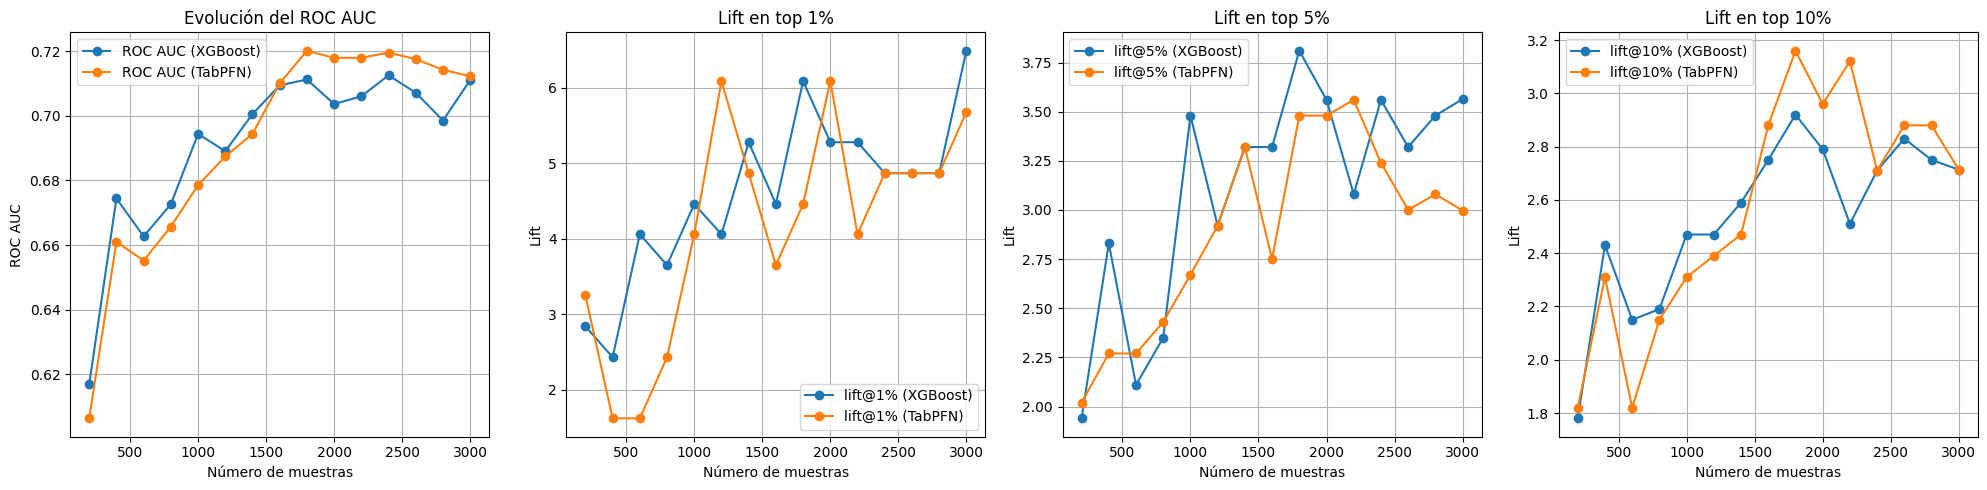

16
Shape X_train: (3200, 30)
Shape y_train: (3200,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 1:53:38.889936
-Métricas XGBoost-
	ROC AUC: 0.7030
	Lift @ top 1%: 5.68x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.96x

-Métricas TabPFN-
	ROC AUC: 0.7151
	Lift @ top 1%: 6.49x
	Lift @ top 5%: 3.08x
	Lift @ top 10%: 2.79x


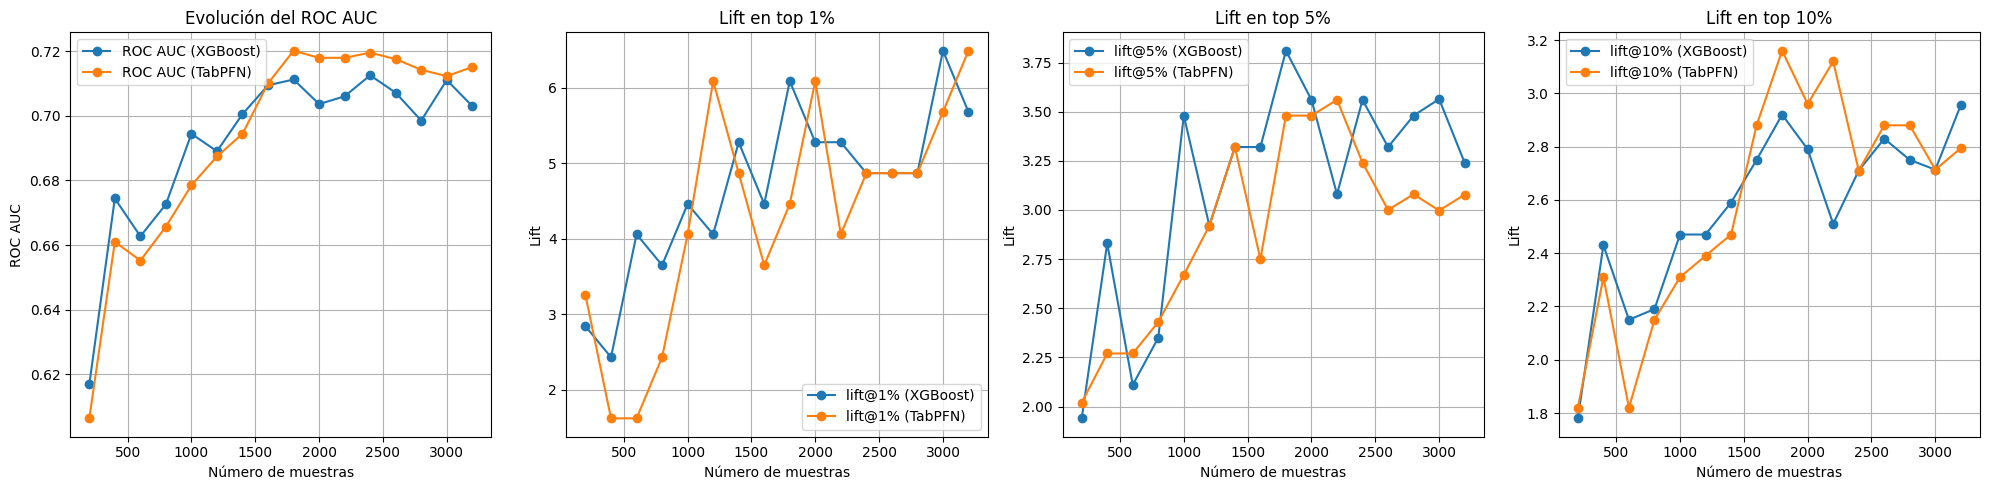

17
Shape X_train: (3400, 30)
Shape y_train: (3400,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 2:04:33.100371
-Métricas XGBoost-
	ROC AUC: 0.7108
	Lift @ top 1%: 6.09x
	Lift @ top 5%: 3.32x
	Lift @ top 10%: 2.67x

-Métricas TabPFN-
	ROC AUC: 0.7161
	Lift @ top 1%: 6.49x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.96x


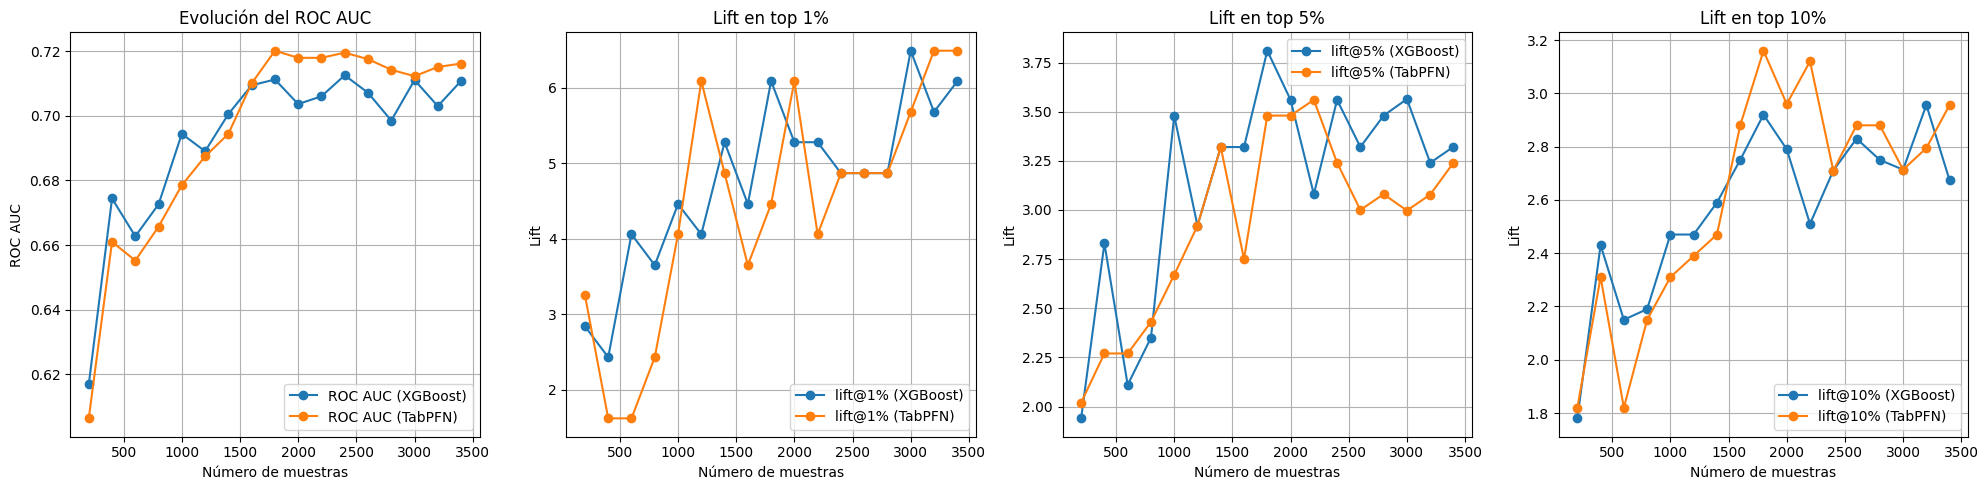

18
Shape X_train: (3600, 30)
Shape y_train: (3600,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 2:17:29.671785
-Métricas XGBoost-
	ROC AUC: 0.7203
	Lift @ top 1%: 5.68x
	Lift @ top 5%: 3.32x
	Lift @ top 10%: 2.63x

-Métricas TabPFN-
	ROC AUC: 0.7186
	Lift @ top 1%: 6.09x
	Lift @ top 5%: 3.00x
	Lift @ top 10%: 2.75x


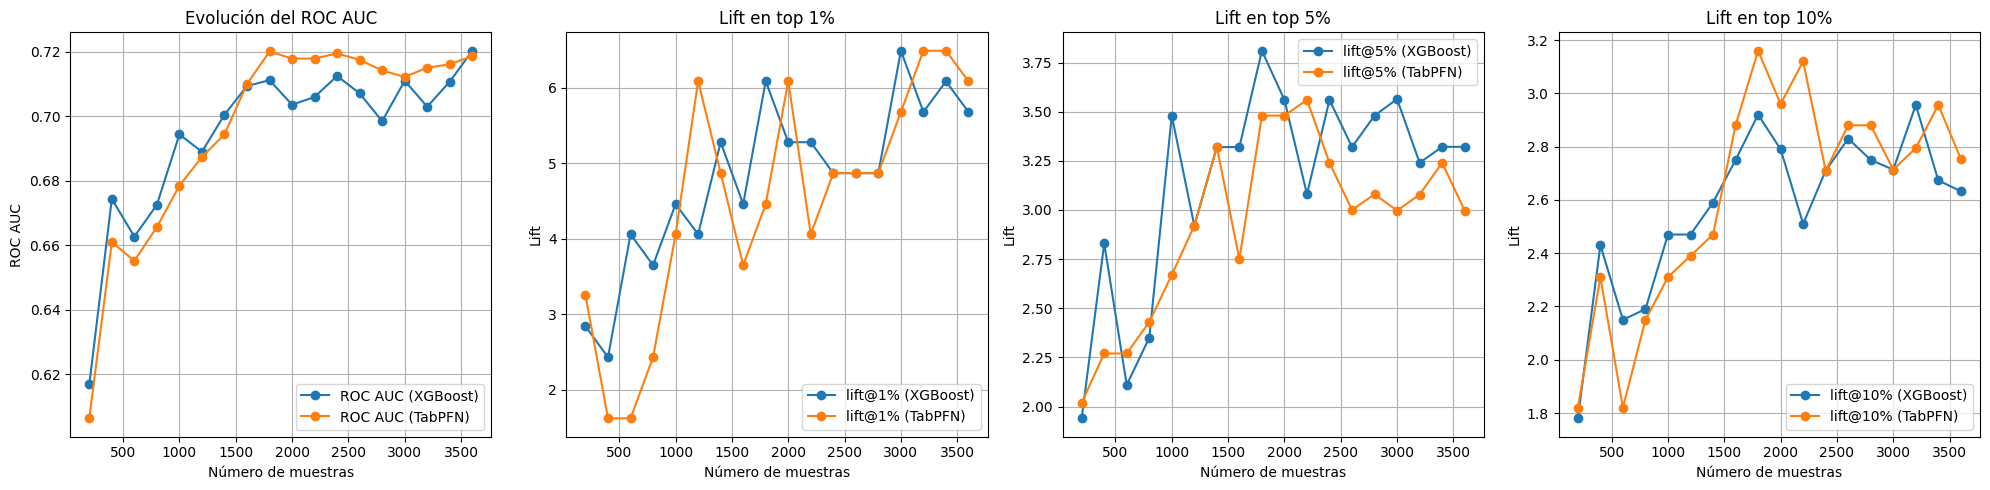

19
Shape X_train: (3800, 30)
Shape y_train: (3800,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 2:34:26.621880
-Métricas XGBoost-
	ROC AUC: 0.7137
	Lift @ top 1%: 6.90x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 3.04x

-Métricas TabPFN-
	ROC AUC: 0.7158
	Lift @ top 1%: 5.68x
	Lift @ top 5%: 3.48x
	Lift @ top 10%: 2.79x


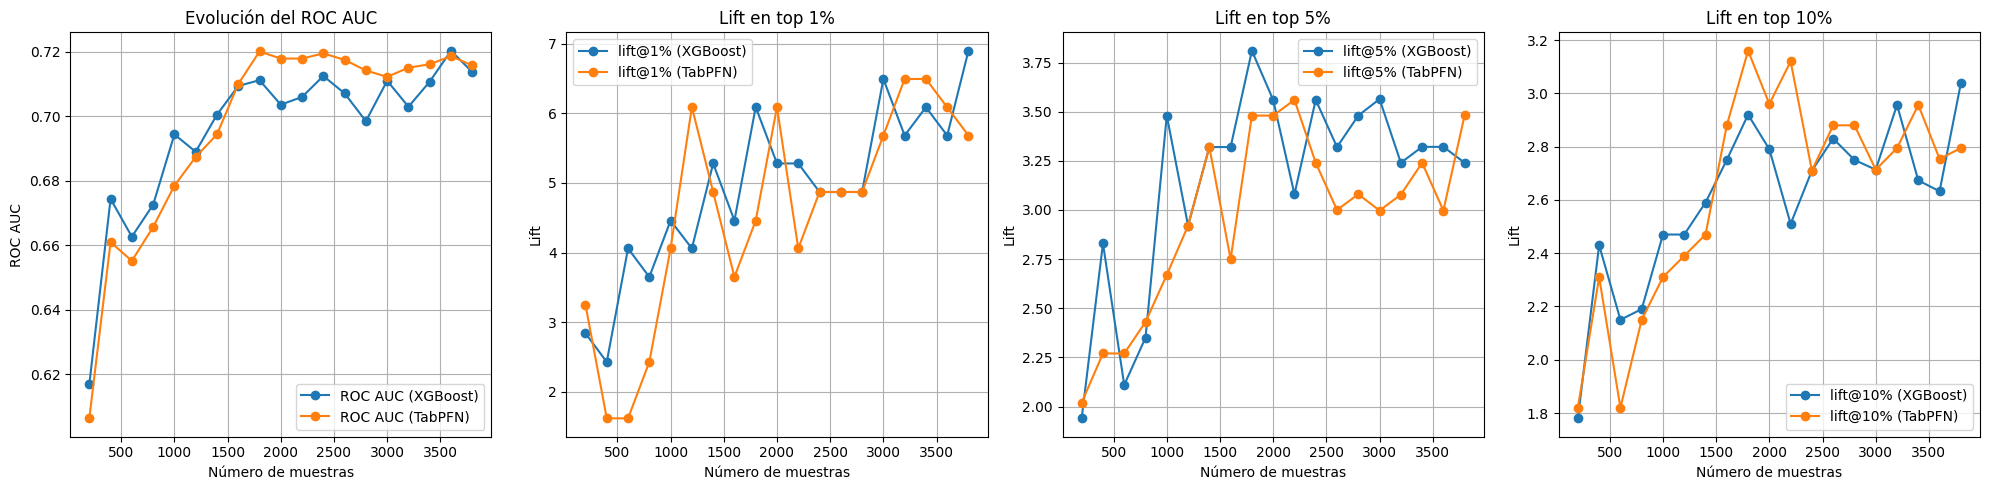

20
Shape X_train: (4000, 30)
Shape y_train: (4000,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 2:49:50.023382
-Métricas XGBoost-
	ROC AUC: 0.6958
	Lift @ top 1%: 6.09x
	Lift @ top 5%: 3.32x
	Lift @ top 10%: 2.75x

-Métricas TabPFN-
	ROC AUC: 0.7141
	Lift @ top 1%: 5.28x
	Lift @ top 5%: 3.00x
	Lift @ top 10%: 2.83x


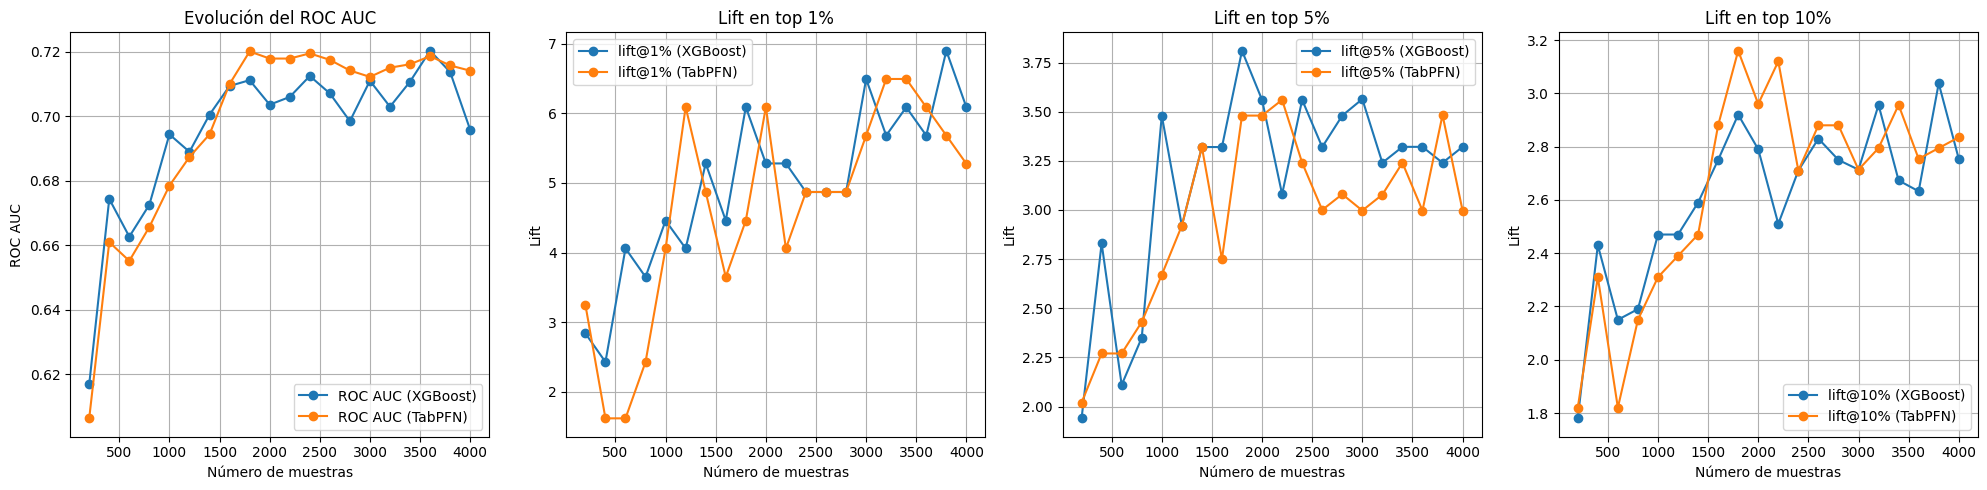

21
Shape X_train: (4200, 30)
Shape y_train: (4200,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

Tiempo de inferencia TabPFN: 3:06:03.002031
-Métricas XGBoost-
	ROC AUC: 0.7140
	Lift @ top 1%: 4.87x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.75x

-Métricas TabPFN-
	ROC AUC: 0.7171
	Lift @ top 1%: 5.28x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.88x


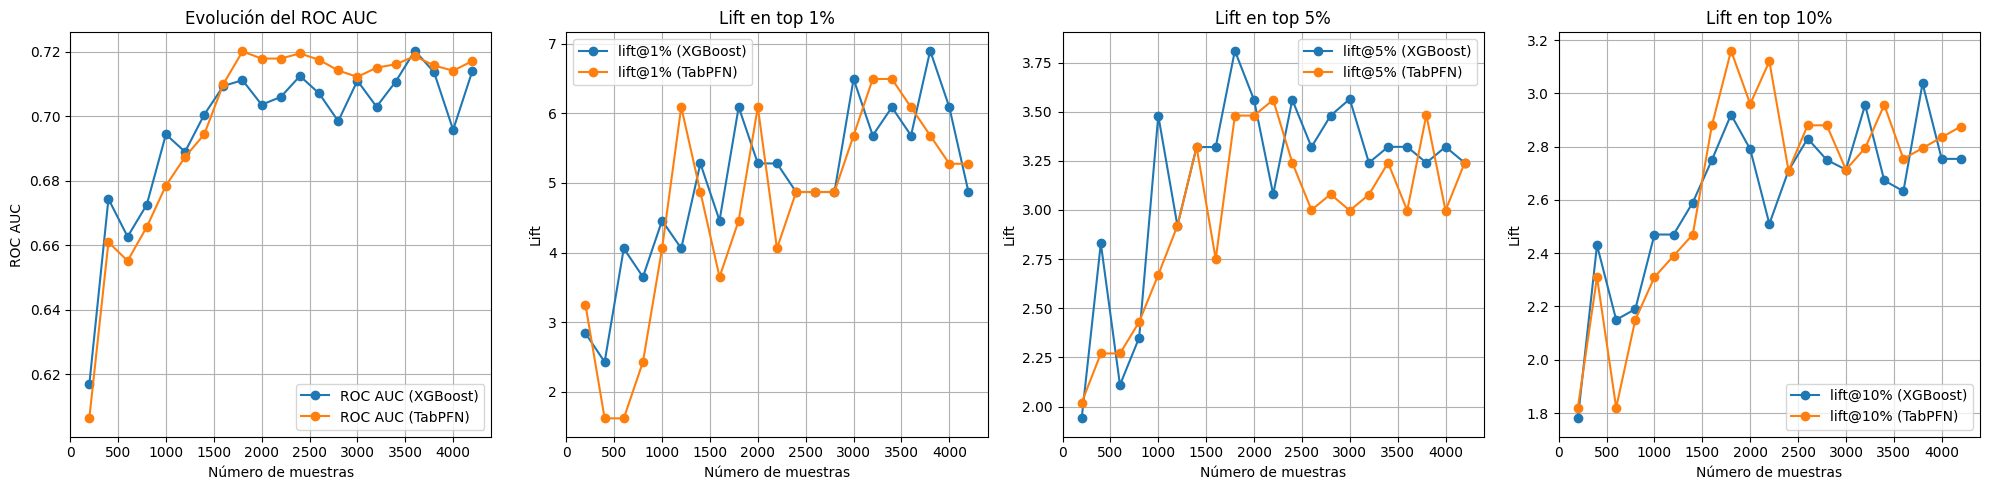

22
Shape X_train: (4400, 30)
Shape y_train: (4400,)


Procesando batches de entrenamiento para TabPFN:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
auc_xgb=[]
lifts_xgb=[]

auc_tabpfn=[]
lifts_tabpfn=[]

num_muestras=[]

num = [e*100 for e in range(1, 25)]
for i, e in enumerate(num):
    print(i+1)
    carry = 0
    if e > df_train.filter(pl.col("target") == 1).shape[0]:
        df_positivos = df_train.filter(pl.col("target") == 1)
        carry = e - df_positivos.shape[0]
    else:
        df_positivos = df_train.filter(pl.col("target") == 1).sample(n=e, seed=42)

    df_negativos = df_train.filter(pl.col("target") == 0).sample(n=e+carry, seed=42)

    df_sec = pl.concat([df_positivos, df_negativos])
    X_train = df_sec.select(cs)
    y_train = df_sec["target"]

    print("Shape X_train:", X_train.shape)
    print("Shape y_train:", y_train.shape)
    num_muestras.append(X_train.shape[0])

    _, xgb_m = optimizar_xgboost_bayesiana(X_train, y_train, n_iter=35, cv=4)

    tabpfn_m = TabPFNClassifier(ignore_pretraining_limits=True)
    tabpfn_m.fit(X_train, y_train)

    y_pred_xgb_m = xgb_m.predict_proba(X_test)[:, 1]
    st = time.time()
    y_pred_tabpfn = predict_en_batches(tabpfn_m, X_test.to_pandas())
    print(f"Tiempo de inferencia TabPFN: {timedelta(seconds=time.time() - st)}")

    print("-Métricas XGBoost-")
    a_xgb, l_xgb = evaluar_modelo(y_test, y_pred_xgb_m)
    print()
    print("-Métricas TabPFN-")
    a_tabpfn, l_tabpfn = evaluar_modelo(y_test, y_pred_tabpfn)

    auc_xgb.append(a_xgb)
    lifts_xgb.append(l_xgb)

    auc_tabpfn.append(a_tabpfn)
    lifts_tabpfn.append(l_tabpfn)
    
    
    if i>13:
        # Visualización en cada iteración
        df_metrics_xgb = pl.DataFrame({
            "n_features": num_muestras,
            "roc_auc": auc_xgb,
            "lift@1%": [x[1] for x in lifts_xgb],
            "lift@5%": [x[5] for x in lifts_xgb],
            "lift@10%": [x[10] for x in lifts_xgb]
        })

        df_metrics_tabpfn = pl.DataFrame({
            "n_features": num_muestras,
            "roc_auc": auc_tabpfn,
            "lift@1%": [x[1] for x in lifts_tabpfn],
            "lift@5%": [x[5] for x in lifts_tabpfn],
            "lift@10%": [x[10] for x in lifts_tabpfn]
        })

        graficar_metricas_comparadas(
            df_metrics_xgb,
            df_metrics_tabpfn,
            nombre_modelo_1="XGBoost",
            nombre_modelo_2="TabPFN",
            lift_percentiles=[1, 5, 10]
        )
